In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
# A helper function for downloading files
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

# Hands-on Activity 26.3 (Physics-informed regularization: Solving uncertainty propagation problems) 

## Objectives

+ Learn how to solve stochastic PDEs with neural networks.


In [4]:
import numpy as np
import torch
import torch.nn as nn

# This is useful for taking derivatives:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

## Solving stochastic PDEs

Consider the boundary value problem we introduced back in [Hands-on Activity 10.4](http://localhost:8888/notebooks/me597/data-analytics-se/activities/hands-on-10.4.ipynb). We have a heterogeneous rod with no heat sources.
The temperature of the rod is governed by the steady state heat equation on:
$$
\frac{d}{dx}\left(c(x,\xi)\frac{d}{dx}T(x)\right) = 0,
$$
for $x$ between $0$ and $1~\;\mbox{m}$ and boundary values:
$$
T(0) = 400^\circ\mbox{C}\;\mbox{and}\;T(1~\mbox{m}) = 4^\circ\mbox{C}.
$$
We are interested in cases in which we are uncertain about the conductivity, $c(x,\xi)$.
Here $\xi$ captures all the information that you need to specify the conductivity.
Let's recall the model we used for the conductivity back in 10.4:

In [9]:
class Rod(object):
    
    """
    A class representing a rod made out of different materials.
    
    Arguments:
    
    segment_coords   -   Coordinates of the segments (both left and right). Total N + 1
                         if segments are N.
    mat_id           -   The material ids on each segment. Total N. Values must start
                         at 0 and go sequential to the maximum number of materials
                         we have on the rod.
    mat_cond         -   The conductivity associaed with each unique material id.
    """
    
    def __init__(self, segment_coords, mat_id, mat_cond):
        # Save segments for later
        self.segment_coords = np.sort(segment_coords)
        # The total number of segments
        self.num_segments = self.segment_coords.shape[0] - 1
        # Save the material id on each segment for later
        self.mat_id = mat_id
        # The number of unique materials
        self.num_mat = len(np.unique(self.mat_id))
        # The conductivity on each segment
        self.segment_cond = np.array([mat_cond[m] for m in mat_id])
        
    def _get_conductivity(self, x):
        """
        Evaluate the conductivity at location x, assuming x is a scalar.
        """
        # Find the segment that contains x
        for i in range(self.num_segments):
            if self.segment_coords[i] <= x and x <= self.segment_coords[i + 1]:
                return self.segment_cond[i]
            
    def get_conductivity(self, x):
        """
        Evaluate the conductivity at location x. This works when x is a scalar or
        a numpy array.
        """
        if isinstance(x, float):
            return self._get_conductivity(x)
        # This checks if x is a numpy array. The function will fail other wise.
        assert isinstance(x, np.ndarray)
        # And it will only work with 1D arrays
        assert x.ndim == 1
        # This evaluates the conductivity at all the elements of x and returns
        # a numpy array
        return np.array([self._get_conductivity(xx) for xx in x])
    
    def __repr__(self):
        """
        Get a string representation of the rod.
        """
        s = 'SEGID\tLeft\tRight\tMat.\tCond.\n'
        s += '-' * 37 + '\n'
        for i in range(self.num_segments):
            s += ' {0:d}\t{1:1.2f}\t{2:1.2f}\t{3:d}\t{4:1.2f}\n'.format(i, segment_coords[i],
                                                                 segment_coords[i+1],
                                                                 material_on_each_segment[i],
                                                                 segment_cond[i])
        return s
    
    def plot(self, ax=None):
        """
        Plots the bar. Returns the axes object on which the rod is plot.
        
        Arguments:
        
        ax    -    An axes object to plot on. If not given, a new one will be created.
        """
        from matplotlib.patches import Rectangle
        if ax is None:
            fig, ax = plt.subplots()
        for i in range(self.num_segments):
            mat_segment = Rectangle((self.segment_coords[i], -0.1), 
                                    width=self.segment_coords[i+1] - self.segment_coords[i],
                                    height=0.1, color=sns.color_palette()[self.mat_id[i]])
            ax.add_patch(mat_segment)
        ax.set_ylim(-0.1, 1.1)
        return ax
    

class RandomRod(object):
    
    """
    A class modeling a random rod.
    
    Arguments:
    
    av_num_segments    -    The ``rate`` of the Poisson distribution giving
                            the number of segments.
    mat_probs          -    The probabilities of the categorical specifying
                            each material goes on each segment.
    mat_cond         -   The conductivity associaed with each unique material id.
    """
    
    def __init__(self, av_num_segments, mat_probs, mat_cond):
        # Save some info internally for later usage
        self.av_num_segments = av_num_segments
        self.mat_probs = mat_probs
        self.mat_cond = mat_cond
        # Make the Poisson variable corresponding to the number of segments
        self.D = st.poisson(av_num_segments)
        # Make the Uniform giving the location of the segment coordinates
        self.U = st.uniform()
        # Make the Categorical random variable that allows us to pick the material
        # id on each segment
        self.M = st.rv_discrete(name='M', values=(np.arange(len(mat_probs)), mat_probs))
        
    def _rvs(self):
        """
        Generate a single random rod.
        """
        # Draw the number of segments
        d = self.D.rvs()
        # Draw the coordinates
        segment_coords = np.hstack([[0.0], np.sort(self.U.rvs(size=d - 1)), [1.0]])
        # Draw the material type on each segment
        mat_ids = self.M.rvs(size=d)
        # Generate the rod
        return Rod(segment_coords, mat_ids, self.mat_cond)
    
    def rvs(self, size=1):
        """
        Generate many random rods.
        """
        if size == 1:
            return self._rvs()
        return [self._rvs() for _ in range(size)]

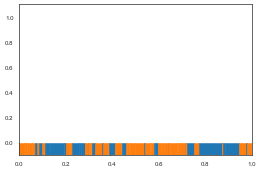

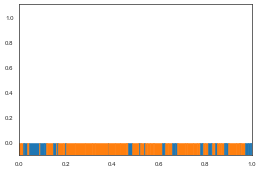

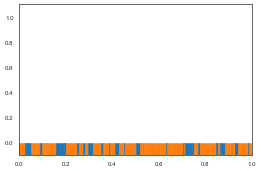

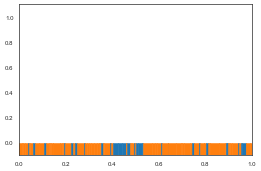

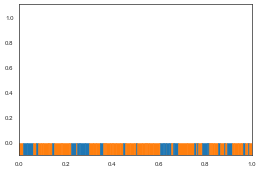

In [12]:
# Create the random rod object
R = RandomRod(100,         # The number of segments
              [0.3, 0.7],  # The concentration of each material
              [0.045, 38.0])  # The thermal conductivity of each material
# Let's sample a few of them and plot them
for n in range(5):
    fig, ax = plt.subplots(dpi=50)
    R.rvs().plot(ax=ax)

We also had a solver for the equation for random rods.
Let's bring it back.

In [ ]:
# Fipy is used to solve the boundary value problem using a finite volume scheme
# You may have to install it if you don't have it using:
# RUN THIS BLOCK IF YOU HAVEN'T INSTALLED fipy yet
!pip install fipy